In [1]:
spark 

In [2]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import some modules we will need later on
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [4]:
# Read the cleaned data
cleaned_data = spark.read.parquet("gs://my-bigdata-project-ns-fhvhv/Cleaned/cleaned_fhvhv_tripdata_2020-*.parquet", header=True, inferSchema=True)

# Show the schema and a few rows for verification
cleaned_data.printSchema()
cleaned_data.show(5)

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_flag: string (nullable = true)
 |-- wav_request_flag: str

+-----------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+-----------

In [5]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Define feature columns
feature_columns = ["trip_time", "base_passenger_fare", "tips"]

# Vectorize feature columns
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = vector_assembler.transform(cleaned_data)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_data = scaler.fit(data_with_features).transform(data_with_features)


In [6]:
# Split the data into training and testing sets
(training_data, testing_data) = scaled_data.randomSplit([0.8, 0.2], seed=123)


# Initialize Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="tips")

# Train the model
lr_model = lr.fit(training_data)

# Define the parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Instantiate the RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="rmse")

# Initialize CrossValidator with the correct evaluator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,  # Use the instantiated evaluator here
                          numFolds=3)

# Train the model with CrossValidator
cv_model = crossval.fit(training_data)

# Make predictions on the testing data using the best model from cross-validation
cv_predictions = cv_model.transform(testing_data)

# Evaluate the best model from cross-validation
cv_rmse = evaluator.evaluate(cv_predictions)

# Print the RMSE from cross-validation
print("Root Mean Squared Error (RMSE) on test data using CrossValidator = %g" % cv_rmse)

# Display the best model's parameters
best_model = cv_model.bestModel
print("Best Model Intercept: ", best_model.intercept)
print("Best Model Coefficients:")
for index, feature in enumerate(feature_columns):
    print(f"{feature}: {best_model.coefficients[index]}")


24/05/17 22:49:04 WARN Instrumentation: [97f401aa] regParam is zero, which might cause numerical instability and overfitting.
24/05/17 22:49:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Root Mean Squared Error (RMSE) on test data using CrossValidator = 0.00844533
Best Model Intercept:  0.002372640249903877
Best Model Coefficients:
trip_time: 0.0
base_passenger_fare: 0.0
tips: 1.5178281924757844


In [7]:
# Save data with features to trusted folder in Parquet format, overwriting if the path already exists
data_with_features.write.mode("overwrite").parquet("gs://my-bigdata-project-ns-fhvhv/Trusted")


# Save the model to models folder, overwriting if the path already exists
lr_model.write().overwrite().save("gs://my-bigdata-project-ns-fhvhv/Models")

   tips  prediction
0   0.0    0.002373
1   0.0    0.002373
2   0.0    0.002373
3   0.0    0.002373
4   0.0    0.002373


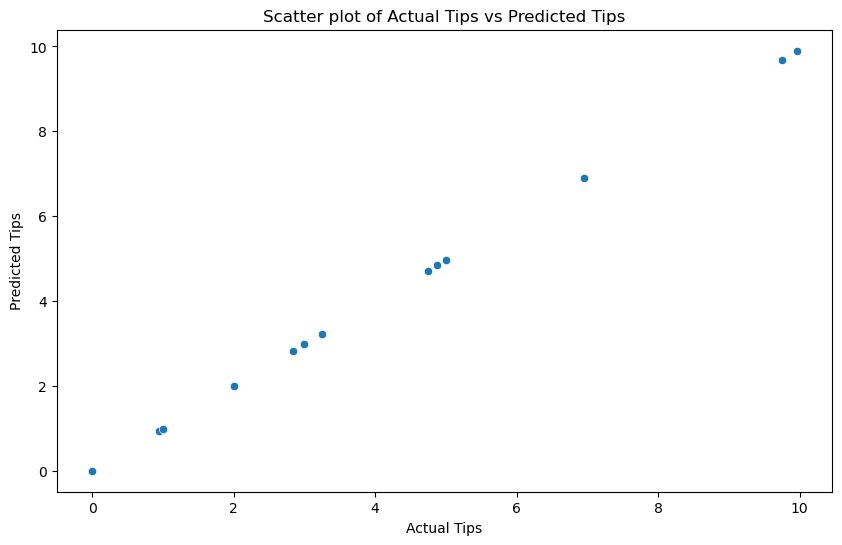

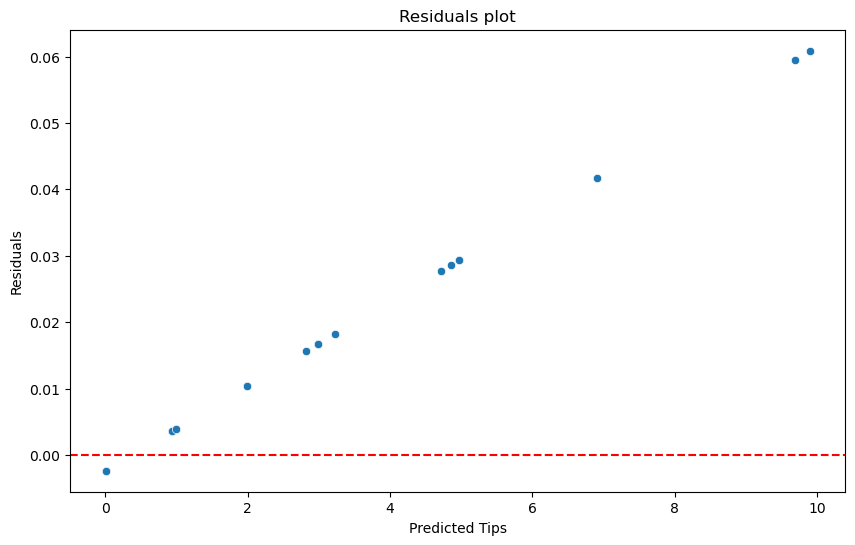

In [8]:
#%%
# Convert the Spark DataFrame to Pandas DataFrame for plotting
pandas_df = cv_predictions.select("tips", "prediction").toPandas()

# Check if pandas_df is correctly created
print(pandas_df.head())

# Create a scatter plot for Actual Tips vs Predicted Tips
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tips", y="prediction", data=pandas_df)
plt.title("Scatter plot of Actual Tips vs Predicted Tips")
plt.xlabel("Actual Tips")
plt.ylabel("Predicted Tips")
plt.show()

# Calculate residuals
pandas_df["residuals"] = pandas_df["tips"] - pandas_df["prediction"]

# Create a scatter plot for Residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residuals", data=pandas_df)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals plot")
plt.xlabel("Predicted Tips")
plt.ylabel("Residuals")
plt.show()